In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from scipy.io import loadmat
import pandas as pd
from sklearn.model_selection import cross_val_score
import seaborn as sns
import collections

Import the data

In [2]:
#import the data

filename =  "datasets/ECGITtrain.mat"

mat = loadmat(filename)
XtrainFull = mat["inputECGITtrain"]
Ytrain = mat["outputECGITtrain"].reshape(len(XtrainFull))
XtestFull = mat["inputECGITtest"]

#print the size of the arrays 
print("XtrainFull", XtrainFull.shape)
print(XtrainFull[-1:,19:26])
print("Ytrain", Ytrain.shape)
print("Xtest", XtestFull.shape)

XtrainFull (200, 312)
[[ 0.         0.         8.6457565 19.581755  21.817047  69.323062
  40.474721 ]]
Ytrain (200,)
Xtest (100, 312)


Feature selection as instructed by physicians to take only dur values

In [3]:
required_columns = [26*i - j - 1 for j in range(0,7) for i in range(1,13)]
required_columns = np.sort(required_columns)
print("These columns will be taken ", required_columns)
print(len(required_columns), "columns in total")
#select only required data from input
Xtrain = XtrainFull[:,required_columns]
Xtest = XtestFull[:,required_columns]
print("Xtrain : ", Xtrain.shape)

These columns will be taken  [ 19  20  21  22  23  24  25  45  46  47  48  49  50  51  71  72  73  74
  75  76  77  97  98  99 100 101 102 103 123 124 125 126 127 128 129 149
 150 151 152 153 154 155 175 176 177 178 179 180 181 201 202 203 204 205
 206 207 227 228 229 230 231 232 233 253 254 255 256 257 258 259 279 280
 281 282 283 284 285 305 306 307 308 309 310 311]
84 columns in total
Xtrain :  (200, 84)


Perform Normalization on the train and test sets 

In [4]:
from sklearn.preprocessing import normalize
#normalise the data
Xtrain = normalize(Xtrain,axis=0)
Xtest = normalize(Xtest,axis=0)

Note : When using un normalised data, a slight drop in accuracy is seen

Visualise the data on two principal components.

<IPython.core.display.Javascript object>


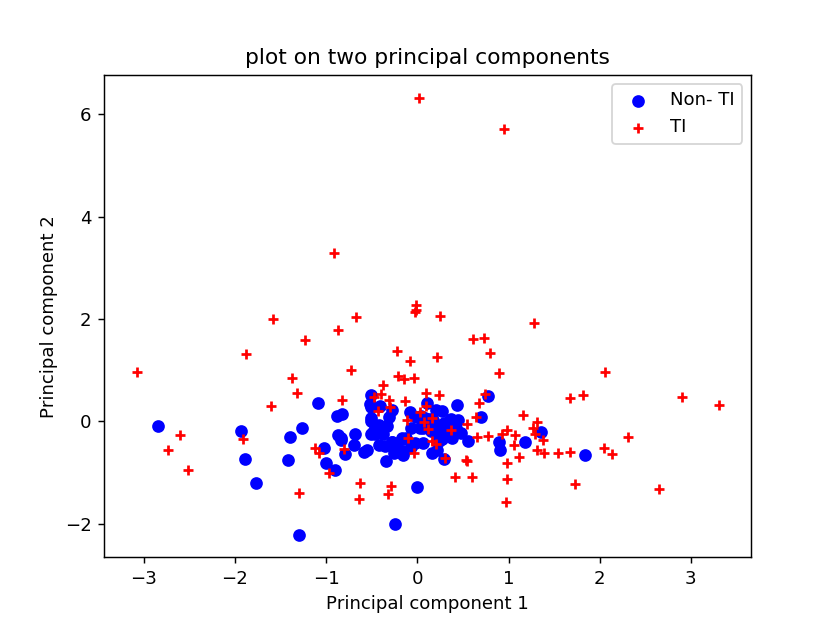

In [5]:
from sklearn.decomposition import PCA
pca_plot = PCA(n_components=2, copy=True, whiten=True, svd_solver='randomized', tol=0.0, iterated_power='auto', random_state=None)
Xtrain_plot = pca_plot.fit_transform(Xtrain)
Xtest_plot = pca_plot.transform(Xtest)
X0, X1 = Xtrain_plot[Ytrain == 0], Xtrain_plot[Ytrain == 1 ]

plt.figure()
plt.scatter(X0[:, 0], X0[:, 1], marker='o', color='b', label='Non- TI')
plt.scatter(X1[:, 0], X1[:, 1], marker='+', color='r', label="TI")
plt.title("plot on two principal components")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend()
plt.show()

Find the variance and do PCA

<IPython.core.display.Javascript object>


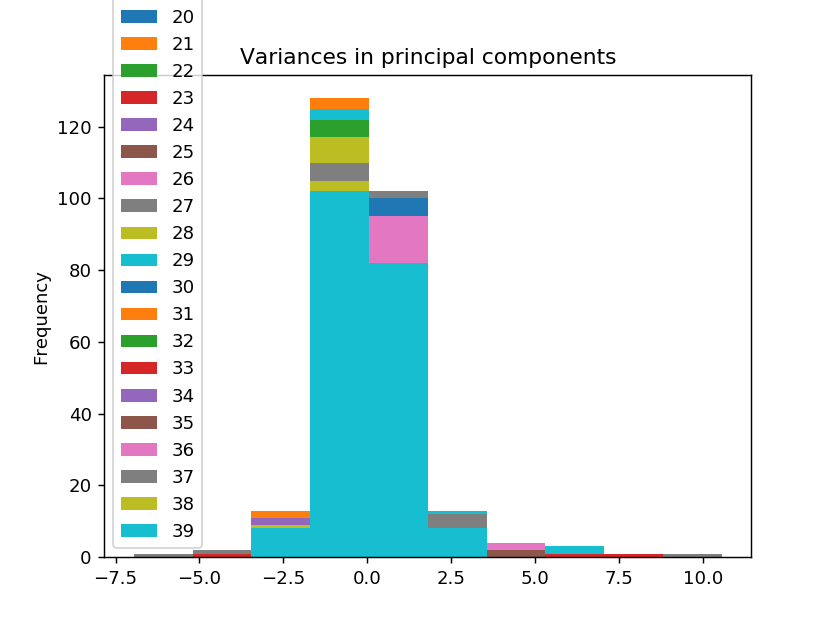

Variance ratios  [0.18443778 0.12338144 0.08950759 0.07165821 0.04814874 0.04423514
 0.0359564  0.03097238 0.02877954 0.02755904 0.02268322 0.01948441
 0.0188744  0.01820882 0.01693724 0.01612146 0.01528381 0.0147917
 0.01386038 0.01359318 0.01222859 0.01045584 0.00968681 0.00838468
 0.00770978 0.00727036 0.00647828 0.00625254 0.00581409 0.00533286
 0.00501729 0.00475881 0.00447966 0.00432706 0.0040595  0.00374141
 0.00335772 0.0032406  0.00288275 0.0027465 ]
Sum of variace ratios  0.9727000112149682


<IPython.core.display.Javascript object>


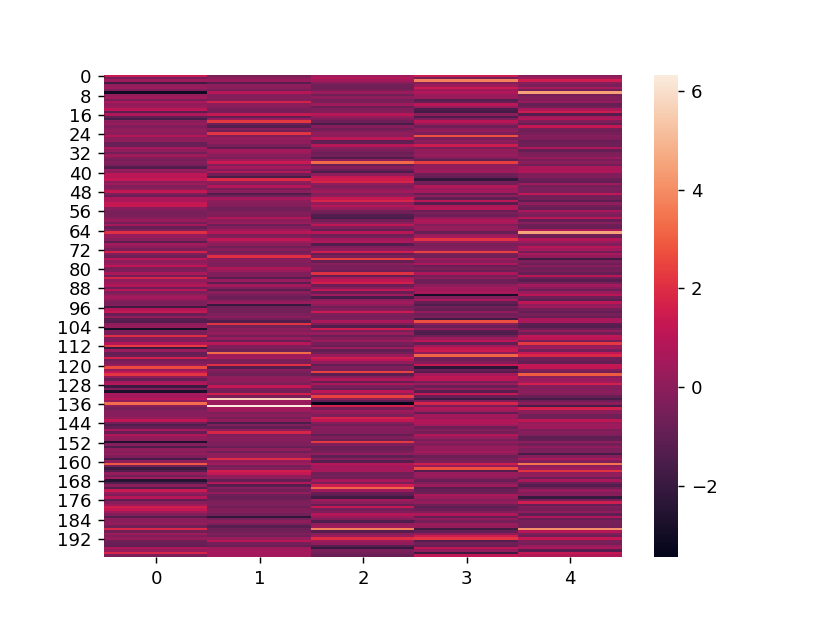

In [6]:
pca = PCA(n_components=40, copy=True, whiten=True, svd_solver='randomized', tol=0.0, iterated_power='auto', random_state=None)
X_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)
#plot both the training data reduced by pca to see the variance in the datset 
pd.DataFrame(X_pca).plot(kind='hist', title='Variances in principal components')
plt.show()
print("Variance ratios ", pca.explained_variance_ratio_)
print("Sum of variace ratios ", np.sum(pca.explained_variance_ratio_))
plt.figure()
ax = sns.heatmap(X_pca[:,:5])

In [7]:
#set cross validation metrics
kf = 10

<IPython.core.display.Javascript object>


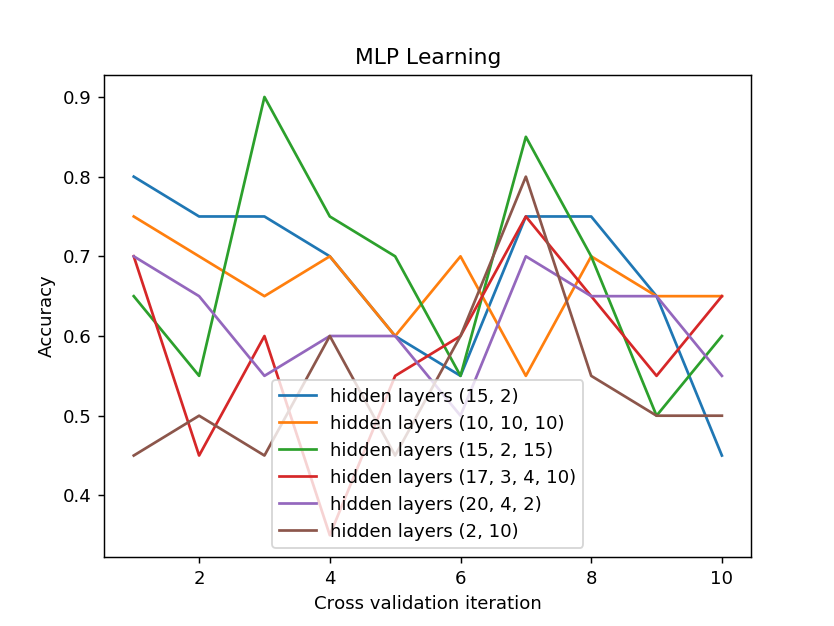

Mean accuracy [0.675, 0.665, 0.675, 0.585, 0.615, 0.54]
Maximum accuracy 0.675
Optimal Number of hidden layers (15, 2)


In [13]:
#Try MLP classifier
from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
mean_accuracy = []
hl_numbers  = [(15, 2), (10, 10, 10), (15, 2, 15) , (17, 3, 4, 10), (20, 4, 2), (2,10)]
plt.figure()
for hl in hl_numbers:
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=hl, random_state=1,max_iter=500)
    scores_mlp = cross_val_score(mlp, X_pca, Ytrain, cv=kf)
    mean_accuracy.append(scores_mlp.mean())
    plt.plot(range(1, len(scores_mlp)+1),scores_mlp , label="hidden layers {}".format(hl))
plt.ylabel("Accuracy")
plt.xlabel("Cross validation iteration")
plt.title("MLP Learning")
plt.legend()
plt.show()
print("Mean accuracy", mean_accuracy)
max_accuracy = max(mean_accuracy)
print("Maximum accuracy", max_accuracy)
print("Optimal Number of hidden layers", hl_numbers[mean_accuracy.index(max_accuracy)])

<IPython.core.display.Javascript object>


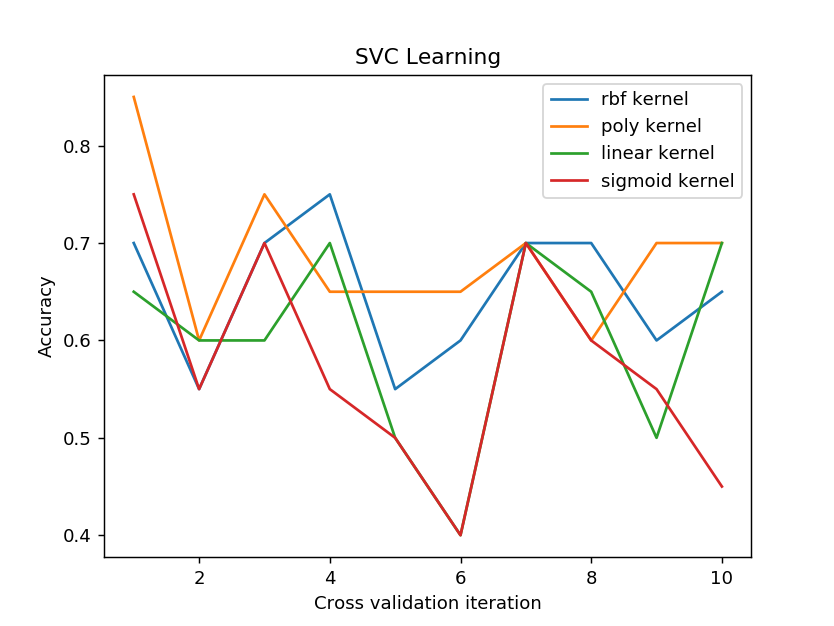

Maximum accuracy 0.6849999999999999
Best method ' poly ' kernel


In [9]:
#try SVM classifier
from sklearn.svm import SVC
kernel_arr = ['rbf', 'poly', 'linear', 'sigmoid']
mean_accuracy = []
plt.figure()
for kernel in kernel_arr:
    svc = SVC(kernel=kernel, C=1, gamma='scale', degree=3, coef0=1)
    scores_svc = cross_val_score(svc, X_pca, Ytrain, cv=kf)
    mean_accuracy.append(scores_svc.mean())
    plt.plot(range(1, len(scores_svc)+1),scores_svc, label='%s kernel'%kernel)
plt.ylabel("Accuracy")
plt.xlabel("Cross validation iteration")
plt.title("SVC Learning")
plt.legend()
plt.show()
max_accuracy = max(mean_accuracy)
print("Maximum accuracy", max_accuracy)
print("Best method '", kernel_arr[mean_accuracy.index(max_accuracy)],"' kernel" )

<IPython.core.display.Javascript object>


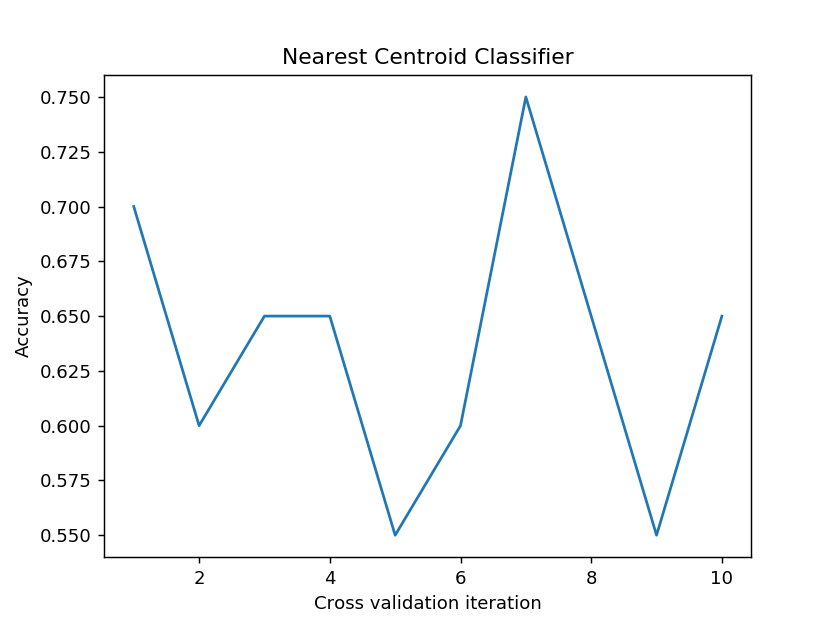

The mean accuracy is 0.635


In [10]:
#try nearest centroid classification
from sklearn.neighbors import NearestCentroid
ncd = NearestCentroid()
scores_ncd = cross_val_score(ncd, X_pca, Ytrain, cv=kf)
plt.figure()
plt.plot(range(1,11), scores_ncd)
plt.title("Nearest Centroid Classifier")
plt.xlabel("Cross validation iteration")
plt.ylabel("Accuracy")
plt.show()
mean_accuracy = scores_ncd.mean()
print("The mean accuracy is", mean_accuracy)

<IPython.core.display.Javascript object>


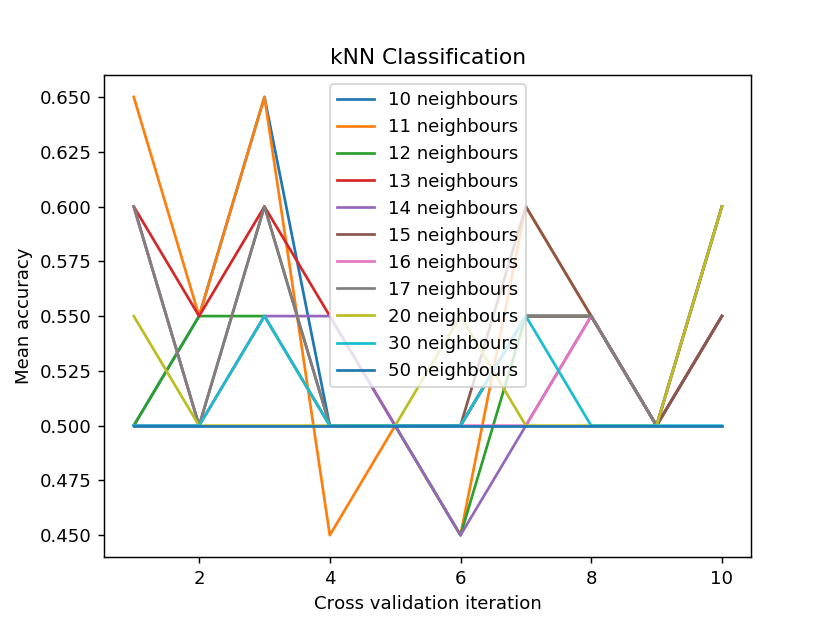

Optimal value for k is 11 with 0.55 accuracy score


In [11]:
#try kNN classification
from sklearn.neighbors import KNeighborsClassifier
k_numbers = [10, 11, 12, 13, 14, 15, 16, 17, 20, 30, 50]
mean_accuracy = []
plt.figure()
for k in k_numbers:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores_knn = cross_val_score(knn, X_pca, Ytrain, cv=kf)
    mean_accuracy.append(scores_knn.mean())
    plt.plot(range(1, len(scores_knn)+1),scores_knn, label='%s neighbours'%k)
plt.title("kNN Classification")
plt.xlabel("Cross validation iteration")
plt.ylabel("Mean accuracy")
plt.legend()
plt.show()
max_accuracy = (max(mean_accuracy))
optimal_k = k_numbers[mean_accuracy.index(max_accuracy)]
print("Optimal value for k is {} with {} accuracy score".format(optimal_k, max_accuracy))

We can see that the Support Vector classifier  with a polynomial kernel gives a slightly improved accuracy when compared to the other methods and so we will use that to predict our test values

<IPython.core.display.Javascript object>


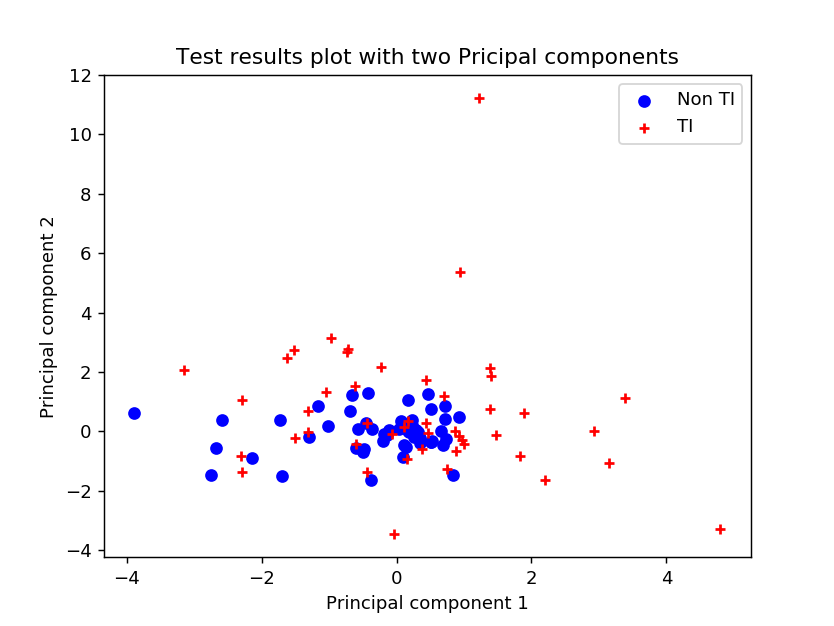

53 Non TI and 47 TI cases predicted by the Support Vector classifier with neighbours 


In [12]:
svc = SVC(kernel='poly', C=1, gamma='scale', degree=3, coef0=1)
svc.fit(X_pca, Ytrain)
Ytest = svc.predict(Xtest_pca)
XT0, XT1 = Xtest_plot[Ytest == 0], Xtest_plot[Ytest == 1]
plt.figure()
plt.scatter(XT0[:, 0], XT0[:, 1], color="blue", marker="o", label="Non TI")
plt.scatter(XT1[:, 0], XT1[:, 1], color="red", marker="+", label="TI")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Test results plot with two Pricipal components")
plt.legend()
plt.show()
#print(collections.Counter(Ytest))
print("{} Non TI and {} TI cases predicted by the Support Vector classifier with neighbours ".format(collections.Counter(Ytest)[0],collections.Counter(Ytest)[1]))